In [1]:
import pandas as pds
import numpy as np
import textdistance
import timeit
import math
import statsmodels.api as sm
import scipy
from patsy import dmatrix
import time
import math
import tqdm

name_DF = 'DF_N=4401_2023-01-16.csv'
DF = pds.read_csv(os.path.join('..', 'datasets', name_DF), delimiter = ',')
DF = DF[~DF.duplicated()] # delete duplicates
DF = DF.dropna() # delete NaN values
DF['was_assigned_female'] = DF['was_assigned_female'].astype('int32') # turn was_born_female into int type (once Nan values have been removed)

identifiers = {'family_name':'jaro-winkler','was_assigned_female':'strict','country':'strict','birth_year':'large'}
covariates = ['X1','X2','X3','X4','X5']

########## GENERATES ASSOCIATION ##########           

# generate covariates
DF['X1'] = 2020 - DF['birth_year'] # age
DF['X2'] = np.random.normal(loc = 2.5, scale = 1, size = DF.shape[0])
DF['X3'] = np.random.normal(loc = 0, scale = 1, size = DF.shape[0])
DF['X4'] = np.random.normal(loc = 1, scale = 1, size = DF.shape[0])
DF['X5'] = np.random.normal(loc = 1, scale = 1, size = DF.shape[0])

# generate treatment
DF['treatment'] = np.random.binomial(n = 1, p = 1 / ( 1 + np.exp(0.1*DF.X1 -0.2*DF.X2 +0.3*DF.X3 -0.4*DF.X4 +0.5*DF.X5) )) # probability depending on covariates

# generate outcome
residual_errors = np.random.normal(size = DF.shape[0])
a = 5.5
b = 0.01
c = 0.08
d = 0.7

ate = a * 2.5
DF['Y'] = - 10 + a*DF['treatment']*DF['X2'] + b*np.exp(DF['X4']) + c*DF['X3']*DF['X1'] + d*DF['X5'] 

common_records = DF.sample(n = 800)

B = pds.concat([DF.sample(n = 1400), common_records]).drop(['Y'], axis = 1)
B = B.reset_index(drop=True)

A = pds.concat([DF.sample(n = 2000), common_records])[list(identifiers.keys())+['Y']]
A = A.reset_index(drop=True)

def levenshtein_similarity(a,b):

    """ Check that levenshtein similarity (in [0,1]) is above 0.95.
        
        a: string,
        b: string """

    if 1 - textdistance.levenshtein(a, b)/max(len(a),len(b)) >= 0.95:
        return 1
    else:
        return 0

def jaro_winkler_similarity(a,b):

    """ Check that jaro-winkler similarity (in [0,1]) is above 0.95.
        
        a: string,
        b: string """

    if textdistance.jaro_winkler(a,b) >= 0.99:
        return 1
    else:
        return 0

def strict_equality(a,b):

    """ Check that a and b values are equal.
        
        a: any value,
        b: any value """

    return a==b

def large_equality(a,b):

    """ Check that years a and b expressed with four numbers are within the same decade.
        
        a: year,
        b: year """

    return str(a)[:-1]==str(b)[:-1]

def logit(p):
    return np.log(p/(1-p))

def minmaxscaler(X):
    return (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
    
def propensity_score(DF, covariates, scaler, convert_to_logit):
    
    """ Compute propensity score estimates: the probability (logistic regression) that an observation is treated or not conditioned on some covariates.
        These estimates are built conditionaly on covariates passed using a logit after transformation by scaler (when one is specified).
        Estimated probabilities can be converted into logit (convert_to_logit parameter).

        DF:                dataframe,
        covariates:        list of strings for covariates variable in DF,
        scaler:            sklearn.preprocessing function scaler for exemple,
        convert_to_logit:  boolean for converting probabilities to logit when building the propensity score estimates based on a logistic regression
    """
    exog = covariates.copy()
    if scaler != None:
        DF[exog] = scaler(DF[exog])
    if 'intercept' not in DF.columns:
        DF['intercept'] = 1
    exog.append('intercept')
    model = sm.Logit(DF.treatment, DF[exog]).fit(disp=0)
    predictions = model.predict(DF[exog])
    if convert_to_logit:
        return logit(predictions)
    else: 
        return predictions

AB = B.merge(A, how='cross')
AB["source_index_B"] = np.repeat(B.index, A.shape[0])
AB["source_index_A"] = np.tile(A.index, B.shape[0])

methods = {'jaro-winkler':jaro_winkler_similarity, 'levenshtein':levenshtein_similarity, 'strict':strict_equality, 'large':large_equality}

for linking_var in identifiers.keys():
    method = methods[identifiers[linking_var]]
    df = AB.filter(regex=linking_var)
    AB[linking_var+"_comparison"] = np.array([method(a, b) for a,b in zip(df.iloc[:,0], df.iloc[:,1])]).astype(int).reshape(-1,1)

comparisons = AB.filter(regex="comparison")

unmatch = comparisons.sum(axis=0) / len(comparisons) # probability of having same linking var (at all)
match = np.repeat(0.95, len(identifiers.keys())) # probability of having same linking var when being matches

AB["linking_score"] = (np.multiply(comparisons, np.log2(match/unmatch)) + np.multiply(1-comparisons, np.log2((1-match)/(1-unmatch)))).sum(axis=1)
AB['propensity_score'] = propensity_score(AB, covariates, None, False)

data = AB[comparisons.all(axis=1)]
data_link = data[ (~data.source_index_A.duplicated(keep=False)) & (~data.source_index_B.duplicated(keep=False)) ]

from_A = A.iloc[data_link.source_index_A,:].reset_index(drop=True)
from_B = B.iloc[data_link.source_index_B,:].reset_index(drop=True)
linked_records = pds.concat([from_B, from_A.Y], axis=1)
linked_records['propensity_score'] = propensity_score(linked_records, covariates, None, False)

z0 = -np.ones(B.shape[0])
z0[data_link.source_index_B] = data_link.source_index_A

true_linkage_z = -np.ones(B.shape[0])
true_linkage_z[B.iloc[-800:,:].index] = A.iloc[-800:,:].index
(z0==true_linkage_z).sum()/len(z0)

0.5172727272727272

In [2]:
linked_records

,name,family_name,country,birth_year,was_assigned_female,X1,X2,X3,X4,X5,treatment,Y,intercept,propensity_score
0,Фаина,Заирова,RU,1976,1,44,2.453919,0.758244,0.959167,1.290137,0,-6.401790,1,0.012453
1,Sara,Rufus,ES,1981,1,39,3.644135,-1.151418,2.248965,2.471388,0,-11.767673,1,0.045281
2,Estelle,Hrns,FR,1962,1,58,2.610547,-0.380868,-0.412286,-0.201746,0,-11.901828,1,0.007363
3,Екатерина,Мороз,RU,1976,1,44,2.791192,-0.027092,2.288318,2.133694,0,-8.503196,1,0.019027
4,Elena,Lolescu,IT,1987,1,33,4.617726,-0.604179,0.362413,1.244581,0,-10.709459,1,0.075146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785,Steve,Davis,GB,1957,0,63,2.135314,0.205527,0.597814,-0.225955,0,-9.104130,1,0.005003
786,Алена,Вааль,RU,1976,1,44,1.448555,2.223036,0.561134,-0.303825,0,-2.370063,1,0.011775
787,Štefica,Frljak,HR,1991,1,29,2.220647,-0.605836,1.187767,1.724859,0,-10.165342,1,0.064350
788,Violetta,Schär,CH,1960,1,60,3.556509,-0.008020,0.991853,1.818817,0,-8.738362,1,0.003742


In [2]:
# def compute_posterior(file_A, file_B, file_mix_BA, linked_records, z, theta_m, theta_u, alpha_pi, beta_pi, sigma_square, a_sigma, b_sigma, beta0, beta1, alpha, mu2, sigma2_square, a_sigma2, b_sigma2):
#     result = 0
#     # likelihood 1
#     # need linked_records computed based on z
#     Y = np.array(linked_records.Y)
#     X = np.array([linked_records.propensity_score*linked_records.treatment, linked_records.propensity_score])
#     X = sm.add_constant(X)
#     X = X.T
#     model = sm.GLM(Y,X)
#     results = model.fit()
#     residuals = Y - X @ results.params
#     estimated_variance = residuals.T @ residuals / (len(residuals) - (X.shape[1]+1))
#     result += np.log(scipy.stats.norm.pdf(residuals, 0, np.sqrt(estimated_variance))).sum()
#     # likelihood 2
#     # need z
#     Y = scipy.stats.norm.rvs(mu2, np.sqrt(sigma2_square), size=len(z[z<0]))
#     result += np.log(scipy.stats.norm.pdf(Y, mu2, np.sqrt(sigma2_square))).sum()
#     # likelihood 3 and 4
#     # need AB, z, theta_m, theta_u ATTENTION AB SHOULD BE KNOWN (GLOBAL)
#     idx_A = z[z>=0]
#     idx_B = np.nonzero(z>=0)[0]
#     links = pds.MultiIndex.from_tuples(zip(idx_A,idx_B))
#     pairs = pds.MultiIndex.from_frame(file_mix_BA[["source_index_A", "source_index_B"]])
#     # 3
#     data = file_mix_BA[pairs.isin(links)] # 1-2-1 matches enforced by construction of z
#     pattern_match, count_match = np.unique(data.filter(regex="comparison"), return_counts=True, axis=0)
#     result += ((pattern_match @ np.log(theta_m) + (1-pattern_match) @ np.log(1-theta_m)) * count_match).sum()
#     # 4
#     data = file_mix_BA[(~file_mix_BA.source_index_B.duplicated())&(~pairs.isin(links))] # enforce 1-2-1 by removing duplicata
#     pattern_unmatch, count_unmatch = np.unique(data.filter(regex="comparison"), return_counts=True, axis=0)
#     result += ((pattern_unmatch @ np.log(theta_u) + (1-pattern_unmatch) @ np.log(1-theta_u)) * count_unmatch).sum()
#     # prior 1
#     # need z, alpha_pi, beta_pi
#     n_AB = (z>=0).sum()
#     result += math.log(math.factorial(file_A.shape[0]-n_AB)) - math.log(math.factorial(file_A.shape[0])) + scipy.special.betaln(n_AB + alpha_pi, file_B.shape[0] - n_AB + beta_pi) - scipy.special.betaln(alpha_pi, beta_pi)
#     # prior 2
#     # need theta_m QUESTION a-1 / b-1?
#     result += (1 * np.log(theta_m) + 1 * np.log(1-theta_m)).sum()
#     # prior 3
#     # need theta_u QUESTION a-1 / b-1?
#     result += (1 * np.log(theta_u) + 1 * np.log(1-theta_u)).sum()
#     # prior 4
#     # need sigma_square, a_sigma, b_sigma QUESTION unclear if it is the pdf?
#     result += np.log(scipy.stats.invgauss.pdf(sigma_square, a_sigma, b_sigma))
#     # prior 5
#     # need beta0, beta1, alpha QUESTION unclear if it is the pdf?
#     result += np.log(scipy.stats.multivariate_normal.pdf([beta0, beta1, alpha], [0,0,0], np.eye(3)))
#     # prior 6
#     # need mu2 QUESTION unclear if it is the pdf?
#     result += np.log(scipy.stats.norm.pdf(mu2, 0, 1))
#     # prior 7
#     # need sigma2_square, a_sigma2, b_sigma2 QUESTION unclear if it is the pdf?
#     result += np.log(scipy.stats.invgauss.pdf(sigma2_square, a_sigma2, b_sigma2))
#     return result

# def compute_proposal(file_A, file_B, file_mix_BA, z, sigma_square, a_sigma, b_sigma, beta0, beta1, alpha, mu2, sigma2_square, a_sigma2, b_sigma2):
#     result = [] # z, linked_records, theta_m, theta_u, beta0, beta1, alpha, sigma_square, mu2, sigma2_square
#     # z
#     linked_record_prop = (z<file_B.shape[0]).sum() / len(z) # proportion of linked records in previous z
#     new = np.random.choice(file_A.shape[0], size=file_B.shape[0], replace=False)
#     new = new * np.random.choice([1,-1], size=file_B.shape[0], p=[linked_record_prop, 1-linked_record_prop]) # randomly set negative some values so that the proportion of positive values corresponds to linked_record_prop
#     result.append(new)
#     # linked records
#     idx_A = z[z>=0]
#     idx_B = np.nonzero(z>=0)[0]
#     from_A = file_A.iloc[idx_A,:].reset_index(drop=True)
#     from_B = file_B.iloc[idx_B,:].reset_index(drop=True)
#     linked_records = pds.concat([from_B, from_A.Y], axis=1)
#     linked_records['propensity_score'] = propensity_score(linked_records, covariates, None, False)
#     result.append(linked_records)
#     # theta_u QUESTION we do not care of dependence on previous param
#     comparisons = file_mix_BA.filter(regex="comparison")
#     unmatch = comparisons.sum(axis=0) / len(comparisons)
#     result.append(unmatch)
#     # theta_m QUESTION we do not care of dependence on previous param
#     match = np.repeat(0.95, len(unmatch))
#     result.append(match)
#     # beta0, beta1, alpha, sigma_square
#     result.append(beta0+scipy.stats.norm.rvs(0,0.5))
#     result.append(beta1+scipy.stats.norm.rvs(0,0.5))
#     result.append(alpha+scipy.stats.norm.rvs(0,0.5))
#     result.append(sigma_square+scipy.stats.invgauss.rvs(a_sigma,b_sigma))
#     # mu2, sigma2_square
#     result.append(mu2+scipy.stats.norm.rvs(0,1))
#     result.append(sigma2_square+scipy.stats.invgauss.rvs(a_sigma2,b_sigma2))
#     return result

In [3]:
# z_k = [z.copy()]

# linked_records_k = [linked_records.copy()]

# theta_m_k = [match.copy()]

# theta_u_k = [unmatch.copy()]

# alpha_pi_k = [1]
# beta_pi_k = [1]

# a_sigma_k = [1]
# b_sigma_k = [1]

# a_sigma2_k = [1]
# b_sigma2_k = [1]

# beta0_k = [scipy.stats.norm.rvs(0,1)]
# beta1_k = [scipy.stats.norm.rvs(0,1)]
# alpha_k = [scipy.stats.norm.rvs(0,1)]
# sigma_square_k = [scipy.stats.invgauss.rvs(a_sigma_k[-1],b_sigma_k[-1])]

# mu2_k = [scipy.stats.norm.rvs(0,1)]
# sigma2_square_k = [scipy.stats.invgauss.rvs(a_sigma2_k[-1],b_sigma2_k[-1])]

# posteriors = []
# posterior = compute_posterior(A, B, AB, linked_records_k[-1], z_k[-1], theta_m_k[-1], theta_u_k[-1], alpha_pi_k[-1], beta_pi_k[-1], sigma_square_k[-1], a_sigma_k[-1], b_sigma_k[-1], beta0_k[-1], beta1_k[-1], alpha_k[-1], mu2_k[-1], sigma2_square_k[-1], a_sigma2_k[-1], b_sigma2_k[-1])
# posteriors.append(posterior)

# for _ in tqdm.tqdm(range(500)):
#     if  not(_%50):
#         print((z_k[-1]==true_linkage_z).sum()/len(true_linkage_z))

#     proposal = compute_proposal(A, B, AB, z_k[-1], sigma_square_k[-1], a_sigma_k[-1], b_sigma_k[-1], beta0_k[-1], beta1_k[-1], alpha_k[-1], mu2_k[-1], sigma2_square_k[-1], a_sigma2_k[-1], b_sigma2_k[-1])
#     new_z, new_linked_records, new_theta_m, new_theta_u, new_beta0, new_beta1, new_alpha, new_sigma_square, new_mu2, new_sigma2_square = proposal
#     # if update z and linked_records
#     new_posterior = compute_posterior(A, B, AB, new_linked_records, new_z, theta_m_k[-1], theta_u_k[-1], alpha_pi_k[-1], beta_pi_k[-1], sigma_square_k[-1], a_sigma_k[-1], b_sigma_k[-1], beta0_k[-1], beta1_k[-1], alpha_k[-1], mu2_k[-1], sigma2_square_k[-1], a_sigma2_k[-1], b_sigma2_k[-1])

#     posteriors.append(new_posterior)
#     U = scipy.stats.uniform.rvs(0,1)
#     if U < posteriors[-1] / posteriors[-2]:
#         z_k.append(new_z)
#         linked_records_k.append(new_linked_records)
#         theta_m_k.append(new_theta_m)
#         theta_u_k.append(new_theta_u)
#         beta0_k.append(new_beta0)
#         beta1_k.append(new_beta1)
#         alpha_k.append(new_alpha)
#         sigma_square_k.append(new_sigma_square)
#         mu2_k.append(new_mu2)
#         sigma2_square_k.append(new_sigma2_square)

In [4]:
# z_k = [z.copy()]

# linked_records_k = [linked_records.copy()]

# theta_m_k = [match.copy()]

# theta_u_k = [unmatch.copy()]

# alpha_pi_k = [1]
# beta_pi_k = [1]

# a_sigma_k = [1]
# b_sigma_k = [1]

# a_sigma2_k = [1]
# b_sigma2_k = [1]

# beta0_k = [scipy.stats.norm.rvs(0,1)]
# beta1_k = [scipy.stats.norm.rvs(0,1)]
# alpha_k = [scipy.stats.norm.rvs(0,1)]
# sigma_square_k = [scipy.stats.invgauss.rvs(a_sigma_k[-1],b_sigma_k[-1])]

# mu2_k = [scipy.stats.norm.rvs(0,1)]
# sigma2_square_k = [scipy.stats.invgauss.rvs(a_sigma2_k[-1],b_sigma2_k[-1])]

# posteriors = []
# posterior = compute_posterior(A, B, AB, linked_records_k[-1], z_k[-1], theta_m_k[-1], theta_u_k[-1], alpha_pi_k[-1], beta_pi_k[-1], sigma_square_k[-1], a_sigma_k[-1], b_sigma_k[-1], beta0_k[-1], beta1_k[-1], alpha_k[-1], mu2_k[-1], sigma2_square_k[-1], a_sigma2_k[-1], b_sigma2_k[-1])
# posteriors.append(posterior)

# for _ in tqdm.tqdm(range(500)):
#     if  not(_%50):
#         print((z_k[-1]==true_linkage_z).sum()/len(true_linkage_z))

#     proposal = compute_proposal(A, B, AB, z_k[-1], sigma_square_k[-1], a_sigma_k[-1], b_sigma_k[-1], beta0_k[-1], beta1_k[-1], alpha_k[-1], mu2_k[-1], sigma2_square_k[-1], a_sigma2_k[-1], b_sigma2_k[-1])
#     new_z, new_linked_records, new_theta_m, new_theta_u, new_beta0, new_beta1, new_alpha, new_sigma_square, new_mu2, new_sigma2_square = proposal
#     # if update z and linked_records
#     new_posterior = compute_posterior(A, B, AB, new_linked_records, new_z, theta_m_k[-1], theta_u_k[-1], alpha_pi_k[-1], beta_pi_k[-1], sigma_square_k[-1], a_sigma_k[-1], b_sigma_k[-1], beta0_k[-1], beta1_k[-1], alpha_k[-1], mu2_k[-1], sigma2_square_k[-1], a_sigma2_k[-1], b_sigma2_k[-1])
#     U = scipy.stats.uniform.rvs(0,1)
#     if U < new_posterior / posteriors[-1]:
#         posteriors.append(new_posterior)
#         z_k.append(new_z)
#         linked_records_k.append(new_linked_records)

#     proposal = compute_proposal(A, B, AB, z_k[-1], sigma_square_k[-1], a_sigma_k[-1], b_sigma_k[-1], beta0_k[-1], beta1_k[-1], alpha_k[-1], mu2_k[-1], sigma2_square_k[-1], a_sigma2_k[-1], b_sigma2_k[-1])
#     new_z, new_linked_records, new_theta_m, new_theta_u, new_beta0, new_beta1, new_alpha, new_sigma_square, new_mu2, new_sigma2_square = proposal
#     # if update theta_m, theta_u
#     new_posterior = compute_posterior(A, B, AB, linked_records_k[-1], z_k[-1], new_theta_m, new_theta_u, alpha_pi_k[-1], beta_pi_k[-1], sigma_square_k[-1], a_sigma_k[-1], b_sigma_k[-1], beta0_k[-1], beta1_k[-1], alpha_k[-1], mu2_k[-1], sigma2_square_k[-1], a_sigma2_k[-1], b_sigma2_k[-1])
#     U = scipy.stats.uniform.rvs(0,1)
#     if U < new_posterior / posteriors[-1]:
#         posteriors.append(new_posterior)
#         theta_m_k.append(new_theta_m)
#         theta_u_k.append(new_theta_u)

#     proposal = compute_proposal(A, B, AB, z_k[-1], sigma_square_k[-1], a_sigma_k[-1], b_sigma_k[-1], beta0_k[-1], beta1_k[-1], alpha_k[-1], mu2_k[-1], sigma2_square_k[-1], a_sigma2_k[-1], b_sigma2_k[-1])
#     new_z, new_linked_records, new_theta_m, new_theta_u, new_beta0, new_beta1, new_alpha, new_sigma_square, new_mu2, new_sigma2_square = proposal
#     # if update beta0, beta1, alpha, sigma_square, mu2, sigma2_square
#     new_posterior = compute_posterior(A, B, AB, linked_records_k[-1], z_k[-1], theta_m_k[-1], theta_u_k[-1], alpha_pi_k[-1], beta_pi_k[-1], new_sigma_square, a_sigma_k[-1], b_sigma_k[-1], new_beta0, new_beta1, new_alpha, new_mu2, new_sigma2_square, a_sigma2_k[-1], b_sigma2_k[-1])
#     U = scipy.stats.uniform.rvs(0,1)
#     if U < new_posterior / posteriors[-1]:
#         posteriors.append(new_posterior)
#         beta0_k.append(new_beta0)
#         beta1_k.append(new_beta1)
#         alpha_k.append(new_alpha)
#         sigma_square_k.append(new_sigma_square)
#         mu2_k.append(new_mu2)
#         sigma2_square_k.append(new_sigma2_square)

In [16]:
# INITIALISATION
# 
z_k = [z0.copy()]

linked_records_k = [linked_records.copy()]

theta_m_k = [match.copy()]

theta_u_k = [unmatch.copy()]

alpha_pi_k = [1]
beta_pi_k = [1]

a_sigma_k = [1]
b_sigma_k = [1]

a_sigma2_k = [1]
b_sigma2_k = [1]

beta0_k = [scipy.stats.norm.rvs(0,1)]
beta1_k = [scipy.stats.norm.rvs(0,1)]
alpha_k = [scipy.stats.norm.rvs(0,1)]
sigma_square_k = [scipy.stats.invgauss.rvs(a_sigma_k[-1],b_sigma_k[-1])]

mu2_k = [scipy.stats.norm.rvs(0,1)]
sigma2_square_k = [scipy.stats.invgauss.rvs(a_sigma2_k[-1],b_sigma2_k[-1])]


cartesian_product_AB = AB.copy()
comparison_vectors = comparisons.copy()
file_A = A.copy()
file_B = B.copy()
previous_z = z_k[-1]
previous_theta_m = theta_m_k[-1]
previous_theta_u = theta_u_k[-1]
previous_beta0 = beta0_k[-1]
previous_beta1 = beta1_k[-1]
previous_alpha = alpha_k[-1]
previous_mu2 = mu2_k[-1]
previous_sigma2_square = sigma2_square_k[-1]
previous_alpha_pi = alpha_pi_k[-1]
previous_beta_pi = beta_pi_k[-1]


new_z_vector = []

w1 = ((np.multiply(comparison_vectors, np.log(previous_theta_m/previous_theta_u)) + np.multiply(1-comparison_vectors, np.log((1-previous_theta_m)/(1-previous_theta_u)))).sum(axis=1))
residuals = cartesian_product_AB.Y - np.array([cartesian_product_AB.intercept, cartesian_product_AB.propensity_score, cartesian_product_AB.propensity_score * cartesian_product_AB.treatment]).T @ np.array([previous_beta0, previous_beta1, previous_alpha]).T
# REMARK: X @ Beta in the residuals computation never evolve since we are using cartesian_product_AB file with all "potential links"
estimated_variance = residuals.T @ residuals / (len(residuals) - (cartesian_product_AB.shape[1]+1))
outcome_distr_matched = scipy.stats.norm.pdf(residuals, 0, np.sqrt(estimated_variance))
outcome_distr_unmatched = scipy.stats.norm.pdf(cartesian_product_AB.Y, previous_mu2, np.sqrt(previous_sigma2_square))
w2 = np.log(outcome_distr_matched/outcome_distr_unmatched)
probabilities = np.array(np.exp(w1+w2))
probabilities = probabilities.reshape(file_B.shape[0], file_A.shape[0])
n_AB_ = np.array([(np.delete(previous_z, j)>=0).sum() for j in range(file_B.shape[0])])
proba_no_link = ((file_A.shape[0] - n_AB_) * (file_B.shape[0] - n_AB_ - 1 + previous_beta_pi) / (n_AB_ + previous_alpha_pi)).reshape(-1,1)



























In [17]:
probabilities = np.concatenate([probabilities, proba_no_link], axis=1)

test_proba = np.divide(probabilities.T, probabilities.sum(axis=1)).T

In [18]:
choice_array = np.arange(file_A.shape[0])
choice_array = np.append(choice_array, -1)
choice_array = np.tile(choice_array, file_B.shape[0]).reshape(file_B.shape[0], file_A.shape[0]+1)

for j in range(file_B.shape[0]):
    #proba_vector = np.divide(probabilities.T, probabilities.sum(axis=1)).T
    #print(proba_vector[:,-1])
    value = np.random.choice(choice_array[j,:], p = test_proba[j,:]) #proba_vector[j,:])
    # if value != -1:
    #     probabilities[:,value] = 0
    new_z_vector.append(value)

new_z_vector = np.array(new_z_vector)

In [20]:
list(new_z_vector)

[1351,
 1351,
 2016,
 2016,
 2016,
 2016,
 2074,
 2016,
 1351,
 1351,
 1351,
 2016,
 2016,
 2016,
 2016,
 2016,
 1351,
 1351,
 2074,
 1351,
 2016,
 2016,
 2016,
 2016,
 2016,
 1351,
 2016,
 2016,
 2016,
 2016,
 2016,
 2016,
 2016,
 2074,
 2016,
 1351,
 2016,
 1351,
 2016,
 1351,
 1351,
 1351,
 2016,
 1351,
 2016,
 1351,
 1351,
 1351,
 1351,
 1351,
 2016,
 2074,
 1351,
 1351,
 2016,
 2016,
 2016,
 2016,
 2016,
 1351,
 1351,
 2074,
 2016,
 2074,
 2016,
 1351,
 2016,
 1351,
 2016,
 1351,
 1351,
 2016,
 1351,
 1351,
 2016,
 2016,
 1351,
 1351,
 1351,
 2016,
 2074,
 2016,
 2016,
 2016,
 1351,
 1351,
 1351,
 1351,
 2016,
 1351,
 1351,
 2016,
 1351,
 1351,
 2016,
 1351,
 1351,
 2016,
 1351,
 1351,
 2074,
 2016,
 1351,
 2074,
 2016,
 1351,
 1351,
 2016,
 1351,
 2016,
 1351,
 1351,
 2016,
 1351,
 2016,
 1351,
 2016,
 1351,
 2016,
 2016,
 1351,
 1351,
 1351,
 1351,
 2016,
 1351,
 1351,
 2074,
 2016,
 1351,
 1351,
 2016,
 1351,
 1351,
 2016,
 2016,
 1351,
 2016,
 1351,
 1351,
 2016,
 1351,
 1351,

In [6]:
def update_linkage_param(cartesian_product_AB, previous_z):

    idx_A = previous_z[previous_z>=0]
    idx_B = np.nonzero(previous_z>=0)[0]
    links = pds.MultiIndex.from_tuples(zip(idx_A,idx_B))
    pairs = pds.MultiIndex.from_frame(cartesian_product_AB[["source_index_A", "source_index_B"]])

    data_match = cartesian_product_AB[pairs.isin(links)]
    comparisons_match = data_match.filter(regex="comparison")
    new_theta_m = scipy.stats.beta.rvs(comparisons_match.sum(axis=0) + 1, (1-comparisons_match).sum(axis=0) + 1)

    data_unmatch = cartesian_product_AB[(~pairs.isin(links)) & (~cartesian_product_AB.source_index_B.duplicated()) & (~cartesian_product_AB.source_index_A.duplicated())]
    # REMARK: we also filtered on duplicata, otherwise data_unmatch is considering too many data and probabilities are too small
    
    comparisons_unmatch = data_unmatch.filter(regex="comparison")
    new_theta_u = scipy.stats.beta.rvs(comparisons_unmatch.sum(axis=0) + 1, (1-comparisons_unmatch).sum(axis=0) + 1)

    return new_theta_m, new_theta_u

update_linkage_param(AB, z_k[-1])

(array([0.99969057, 0.99594506, 0.99835562, 0.99990411]),
 array([0.37951677, 0.61374796, 0.14225913, 0.05368722]))

In [7]:
def update_matched_outcome_param(cartesian_product_AB, previous_z, previous_linked_records, previous_beta0, previsou_beta1, previous_alpha, previous_sigma_square, previous_a_sigma, previous_b_sigma):

    idx_A = previous_z[previous_z>=0]
    idx_B = np.nonzero(previous_z>=0)[0]
    links = pds.MultiIndex.from_tuples(zip(idx_A,idx_B))
    pairs = pds.MultiIndex.from_frame(cartesian_product_AB[["source_index_A", "source_index_B"]])

    tilde_y = previous_linked_records.Y
    tilde_K = np.array([previous_linked_records.intercept, previous_linked_records.propensity_score, previous_linked_records.treatment]).T

    sigma_matrix = np.linalg.inv( tilde_K.T @ tilde_K / previous_sigma_square + np.eye(tilde_K.shape[1]) )
    tilde_K.T @ tilde_y
    mu_vector = sigma_matrix @ tilde_K.T @ tilde_y / previous_sigma_square
    new_beta0, new_beta1, new_alpha = scipy.stats.multivariate_normal.rvs(mu_vector, sigma_matrix)

    n_AB = (previous_z>=0).sum()
    new_sigma_square = scipy.stats.invgauss.rvs(previous_a_sigma + n_AB/2, np.linalg.norm(tilde_y - tilde_K @ np.array([previous_beta0, previsou_beta1, previous_alpha]))**2 / 2 + previous_b_sigma)
    
    return new_beta0, new_beta1, new_alpha, new_sigma_square

update_matched_outcome_param(AB, z_k[-1], linked_records_k[-1], beta0_k[-1], beta1_k[-1], alpha_k[-1], sigma_square_k[-1], a_sigma_k[-1], b_sigma_k[-1])

(-9.002546469939825,
 0.04948591324938434,
 14.220021861754391,
 43720.96613968144)

In [8]:
def update_unmatched_outcome_param(file_A, previous_z, previous_mu2, previous_sigma2_square, previous_a_sigma2, previous_b_sigma2):

    idx_A = previous_z[previous_z>=0]

    n_AB = (previous_z>=0).sum()
    
    non_linked_outcomes = file_A.iloc[~file_A.index.isin(idx_A),:].Y

    new_sigma2_square = scipy.stats.invgauss.rvs(previous_a_sigma2 + (file_A.shape[0]-n_AB)/2, previous_b_sigma2 + ((non_linked_outcomes - previous_mu2)**2 / 2).sum())
    sigma_mu_2_square = 1 / ((file_A.shape[0] -  n_AB)/previous_sigma2_square + 1)
    m_mu_2 = sigma_mu_2_square * (non_linked_outcomes).sum() / previous_sigma2_square
    
    new_mu2 = scipy.stats.norm.rvs(m_mu_2, np.sqrt(sigma_mu_2_square))

    return new_mu2, new_sigma2_square

update_unmatched_outcome_param(A, z_k[-1], mu2_k[-1], sigma2_square_k[-1], a_sigma2_k[-1], b_sigma2_k[-1])

(-7.508458543979305, 111544.88040870492)

In [ ]:
def update_linkage_variable(cartesian_product_AB, comparison_vectors, file_A, file_B, previous_z, previous_theta_m, previous_theta_u, previous_beta0, previous_beta1, previous_alpha, previous_mu2, previous_sigma2_square, previous_alpha_pi, previous_beta_pi, covariates, scaler=None, convert_to_logit=False):

    new_z_vector = []
    #already_taken_values = []

    #print("already_taken_values is empty")

    w1 = ((np.multiply(comparison_vectors, np.log(previous_theta_m/previous_theta_u)) + np.multiply(1-comparison_vectors, np.log((1-previous_theta_m)/(1-previous_theta_u)))).sum(axis=1))
    residuals = cartesian_product_AB.Y - np.array([cartesian_product_AB.intercept, cartesian_product_AB.propensity_score, cartesian_product_AB.propensity_score * cartesian_product_AB.treatment]).T @ np.array([previous_beta0, previous_beta1, previous_alpha]).T
    # REMARK: X @ Beta in the residuals computation never evolve since we are using cartesian_product_AB file with all "potential links"
    estimated_variance = residuals.T @ residuals / (len(residuals) - (cartesian_product_AB.shape[1]+1))
    outcome_distr_matched = scipy.stats.norm.pdf(residuals, 0, np.sqrt(estimated_variance))
    outcome_distr_unmatched = scipy.stats.norm.pdf(cartesian_product_AB.Y, previous_mu2, np.sqrt(previous_sigma2_square))
    w2 = np.log(outcome_distr_matched/outcome_distr_unmatched)
    probabilities = np.array(np.exp(w1+w2))
    probabilities = probabilities.reshape(file_B.shape[0], file_A.shape[0])
    n_AB_ = np.array([(np.delete(previous_z, j)>=0).sum() for j in range(file_B.shape[0])])
    proba_no_link = ((file_A.shape[0] - n_AB_) * (file_B.shape[0] - n_AB_ - 1 + previous_beta_pi) / (n_AB_ + previous_alpha_pi)).reshape(-1,1)
    probabilities = np.concatenate([probabilities, proba_no_link], axis=1)

    choice_array = np.arange(file_A.shape[0])
    choice_array = np.append(choice_array, -1)
    choice_array = np.tile(choice_array, file_B.shape[0]).reshape(file_B.shape[0], file_A.shape[0]+1)

    print(probabilities[:,-1])

    for j in range(file_B.shape[0]):
        proba_vector = np.divide(probabilities.T, probabilities.sum(axis=1)).T
        print(proba_vector[:,-1])
        value = np.random.choice(choice_array[j,:], p = proba_vector[j,:])
        if value != -1:
            probabilities[:,value] = 0
        new_z_vector.append(value)

    new_z_vector = np.array(new_z_vector)

    # idx_A = new_z_vector[new_z_vector>=0]
    # idx_B = np.nonzero(new_z_vector>=0)[0]

    # from_A = A.iloc[idx_A,:].reset_index(drop=True)
    # from_B = B.iloc[idx_B,:].reset_index(drop=True)
    # new_linked_records = pds.concat([from_B, from_A.Y], axis=1)
    # print(new_linked_records)
    #new_linked_records['propensity_score'] = propensity_score(new_linked_records, covariates, None, False)

    return new_z_vector #, new_linked_records

update_linkage_variable(AB, comparisons, A, B, z_k[-1], theta_m_k[-1], theta_u_k[-1], beta0_k[-1], beta1_k[-1], alpha_k[-1], mu2_k[-1], sigma2_square_k[-1], alpha_pi_k[-1], beta_pi_k[-1], covariates)

In [12]:
z0[-1]

2799.0

In [15]:
beta1_k[-1]

-1.8080892454928998

In [13]:
def update_linkage_variable(cartesian_product_AB, comparison_vectors, file_A, file_B, previous_z, previous_theta_m, previous_theta_u, previous_beta0, previous_beta1, previous_alpha, previous_mu2, previous_sigma2_square, previous_alpha_pi, previous_beta_pi, covariates, scaler=None, convert_to_logit=False):

    new_z_vector = []
    #already_taken_values = []

    #print("already_taken_values is empty")

    w1 = ((np.multiply(comparison_vectors, np.log(previous_theta_m/previous_theta_u)) + np.multiply(1-comparison_vectors, np.log((1-previous_theta_m)/(1-previous_theta_u)))).sum(axis=1))
    residuals = cartesian_product_AB.Y - np.array([cartesian_product_AB.intercept, cartesian_product_AB.propensity_score, cartesian_product_AB.propensity_score * cartesian_product_AB.treatment]).T @ np.array([previous_beta0, previous_beta1, previous_alpha]).T
    # REMARK: X @ Beta in the residuals computation never evolve since we are using cartesian_product_AB file with all "potential links"
    estimated_variance = residuals.T @ residuals / (len(residuals) - (cartesian_product_AB.shape[1]+1))
    outcome_distr_matched = scipy.stats.norm.pdf(residuals, 0, np.sqrt(estimated_variance))
    outcome_distr_unmatched = scipy.stats.norm.pdf(cartesian_product_AB.Y, previous_mu2, np.sqrt(previous_sigma2_square))
    w2 = np.log(outcome_distr_matched/outcome_distr_unmatched)
    probabilities = np.array(np.exp(w1+w2))
    probabilities = probabilities.reshape(file_B.shape[0], file_A.shape[0])
    n_AB_ = np.array([(np.delete(previous_z, j)>=0).sum() for j in range(file_B.shape[0])])
    proba_no_link = ((file_A.shape[0] - n_AB_) * (file_B.shape[0] - n_AB_ - 1 + previous_beta_pi) / (n_AB_ + previous_alpha_pi)).reshape(-1,1)
    print(proba_no_link)
    print(probabilities[-1,2799])
    probabilities = np.concatenate([probabilities, proba_no_link], axis=1)

    choice_array = np.arange(file_A.shape[0])
    choice_array = np.append(choice_array, -1)
    choice_array = np.tile(choice_array, file_B.shape[0]).reshape(file_B.shape[0], file_A.shape[0]+1)

    print(probabilities[:,-1])

    for j in range(file_B.shape[0]):
        proba_vector = np.divide(probabilities.T, probabilities.sum(axis=1)).T
        print(proba_vector[:,-1])
        value = np.random.choice(choice_array[j,:], p = proba_vector[j,:])
        if value != -1:
            probabilities[:,value] = 0
        new_z_vector.append(value)

    new_z_vector = np.array(new_z_vector)

    # idx_A = new_z_vector[new_z_vector>=0]
    # idx_B = np.nonzero(new_z_vector>=0)[0]

    # from_A = A.iloc[idx_A,:].reset_index(drop=True)
    # from_B = B.iloc[idx_B,:].reset_index(drop=True)
    # new_linked_records = pds.concat([from_B, from_A.Y], axis=1)
    # print(new_linked_records)
    #new_linked_records['propensity_score'] = propensity_score(new_linked_records, covariates, None, False)

    return new_z_vector #, new_linked_records

update_linkage_variable(AB, comparisons, A, B, z_k[-1], theta_m_k[-1], theta_u_k[-1], beta0_k[-1], beta1_k[-1], alpha_k[-1], mu2_k[-1], sigma2_square_k[-1], alpha_pi_k[-1], beta_pi_k[-1], covariates)

[[3328.136419  ]
 [3320.00121655]
 [3320.00121655]
 ...
 [3320.00121655]
 [3328.136419  ]
 [3328.136419  ]]
40337737661.30371
[3328.136419   3320.00121655 3320.00121655 ... 3320.00121655 3328.136419
 3328.136419  ]
[7.79406471e-101 3.69454952e-104 9.77077616e-103 ... 4.14686648e-102
 9.63943529e-101 5.82277133e-102]
[2.84601235e-100 1.74935213e-099 2.60511810e-098 ... 1.45541406e-101
 3.60313273e-098 1.64971583e-099]
[1.76420518e-95 4.82516711e-92 1.60362691e-97 ... 3.42847472e-94
 2.36971898e-93 5.12549828e-92]
[1.11322256e-87 5.70352600e-89 1.14920726e-87 ... 6.00694077e-89
 1.00904357e-87 6.05077241e-89]
[2.63249406e-84 4.85782341e-83 2.71526857e-84 ... 5.10954982e-83
 2.39200421e-84 5.14635315e-83]
[3.67873562e-77 2.79680099e-76 3.33348347e-79 ... 1.98069227e-78
 4.97508516e-75 2.95547680e-76]
[2.26837679e-72 1.20986471e-73 2.30820881e-72 ... 1.22086061e-73
 2.15096166e-72 1.27747752e-73]
[2.29140168e-72 1.22262752e-73 2.33137582e-72 ... 1.23325647e-73
 2.17359505e-72 1.29096298e-7

KeyboardInterrupt: 

In [18]:
# FULFIL A NEW Z VECTOR:
# 
# j = 3
#set_data = ...[AB['source_index_B']==j]
start = time.time()
new_z_vector = []
already_taken = []

for j in range(B.shape[0]):

    w1 = ((np.multiply(comparisons[AB['source_index_B']==j], np.log(theta_m_k[-1]/theta_u_k[-1])) + np.multiply(1-comparisons[AB['source_index_B']==j], np.log((1-theta_m_k[-1])/(1-theta_u_k[-1])))).sum(axis=1))
    # AB propensity score need to be updated at each iteration!!!
    data = AB[AB['source_index_B']==j]
    residuals = data['Y'] - np.array([data['intercept'], data['propensity_score'], data['propensity_score'] * data['treatment']]).T @ np.array([beta0_k[-1], beta1_k[-1], alpha_k[-1]]).T
    estimated_variance = residuals.T @ residuals / (len(residuals) - (data.shape[1]+1))
    aaa = scipy.stats.norm.pdf(residuals, 0, np.sqrt(estimated_variance))
    bbb = scipy.stats.norm.pdf(data['Y'], mu2_k[-1], np.sqrt(sigma2_square_k[-1]))
    w2 = np.log(aaa/bbb)
    probabilities = np.array(np.exp(w1+w2))

    #
    n_AB_ = (np.delete(z_k[-1], j)>=0).sum()
    probabilities = np.append(probabilities, (A.shape[0] - n_AB_) * (B.shape[0] - n_AB_ - 1 + beta_pi_k[-1]) / (n_AB_ + alpha_pi_k[-1]))

    probabilities = probabilities / (probabilities).sum()
    print(probabilities[-1])

    choice_array = np.arange(A.shape[0])
    choice_array = np.append(choice_array, -1)

    val = np.random.choice(choice_array, p = probabilities)
    # while val in already_taken:
    #     val = -1 #np.random.choice(choice_array, p = probabilities)
    # if val != -1:
    #     already_taken.append(val)
    
    new_z_vector.append(val)
end = time.time()
print(end-start)
new_z_vector

7.517417769712943e-101
3.7362464665969366e-104
8.867964022409384e-103
7.269382495852285e-101
3.867795885318836e-102
6.194674247273422e-102
5.408399960668507e-102
1.0044332603056594e-100
8.869727695920923e-103
1.0138220674459862e-100
5.576197457616881e-102
1.1684642531343415e-100
1.0068776277599328e-100
1.2232090131034918e-100
8.871227112013799e-103
4.6739837913702114e-104
1.0075058251269639e-100
1.0104167319411398e-100
1.0054571991580434e-100
5.671923983587262e-102
3.90361961726214e-102
5.294872640416076e-102
3.835081307457835e-104
1.1113838077018114e-100
7.302260528985453e-103
1.0079462615667104e-100
6.6466547355310885e-102
1.0082556725481581e-100
1.005538422857306e-100
3.1549948020946615e-106
1.0047921113545572e-100
6.448196798997373e-102
7.257661789772852e-101
5.366277287984857e-102
5.329095258262455e-102
5.3092814057825216e-102
5.665579937288436e-102
5.489162492742774e-102
6.027180352756863e-102
1.0117797683449397e-100
6.862007909044522e-103
8.868447794830137e-103
5.460467523651800

[586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 1044,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 1044,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 1044,
 586,
 1044,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 1044,
 586,
 586,
 586,
 586,
 586,
 586,
 1044,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 586,
 1044,
 586,
 586,
 586,
 1044,
 586,
 586,
 586,
 586,
 5

In [20]:
z0

array([ 4.430e+02, -1.000e+00, -1.000e+00, ..., -1.000e+00,  2.798e+03,
        2.799e+03])

In [4]:
### TESTS ###
# 

z_k = [z0.copy()]

linked_records_k = [linked_records.copy()]

theta_m_k = [match.copy()]

theta_u_k = [unmatch.copy()]

alpha_pi_k = [1]
beta_pi_k = [1]

a_sigma_k = [1]
b_sigma_k = [1]

a_sigma2_k = [1]
b_sigma2_k = [1]

beta0_k = [scipy.stats.norm.rvs(0,1)]
beta1_k = [scipy.stats.norm.rvs(0,1)]
alpha_k = [scipy.stats.norm.rvs(0,1)]
sigma_square_k = [scipy.stats.invgauss.rvs(a_sigma_k[-1],b_sigma_k[-1])]

mu2_k = [scipy.stats.norm.rvs(0,1)]
sigma2_square_k = [scipy.stats.invgauss.rvs(a_sigma2_k[-1],b_sigma2_k[-1])]

###

file_all_data = AB.copy()
jj = 1500
comparisons_vector_for_j = comparisons[file_all_data['source_index_B']==jj]

w1 = ((np.multiply(comparisons_vector_for_j, np.log(theta_m_k[-1]/theta_u_k[-1])) + np.multiply(1-comparisons_vector_for_j, np.log((1-theta_m_k[-1])/(1-theta_u_k[-1])))).sum(axis=1))
data_for_j = file_all_data[file_all_data['source_index_B']==jj].copy()
residuals = data_for_j.Y - np.array([data_for_j.intercept, data_for_j.propensity_score, data_for_j.propensity_score*data_for_j.treatment]).T @ np.array([beta0_k[-1], beta1_k[-1], alpha_k[-1]]).T
estimated_variance = residuals.T @ residuals / (len(residuals) - (data.shape[1]+1))
aaa = scipy.stats.norm.pdf(residuals, 0, np.sqrt(estimated_variance))
bbb = scipy.stats.norm.pdf(data_for_j.Y, mu2_k[-1], np.sqrt(sigma2_square_k[-1]))
w2 = np.log(aaa/bbb)
probabilities = np.array(np.exp(w1+w2))

#
n_AB_ = (np.delete(z_k[-1], jj)>=0).sum()
#print("n AB -",n_AB_)

#print("proba du -1", (A.shape[0] - n_AB_) * (B.shape[0] - n_AB_ - 1 + beta_pi_k[-1]) / (n_AB_ + alpha_pi_k[-1]))
probabilities = np.append(probabilities, (A.shape[0] - n_AB_) * (B.shape[0] - n_AB_ - 1 + beta_pi_k[-1]) / (n_AB_ + alpha_pi_k[-1]))
#print("proba avec -1",probabilities)

probabilities = probabilities / (probabilities).sum()
# print(probabilities[0],probabilities[-1])

choice_array = np.arange(A.shape[0])
choice_array = np.append(choice_array, -1)

for _ in range(100):
    val = np.random.choice(choice_array, p = probabilities)
    print(val)

1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1497
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802
1802


In [5]:
test_proba = probabilities / (probabilities).sum()
test_proba

array([2.49859166e-60, 2.57343341e-73, 3.56116496e-71, ...,
       2.95100429e-82, 1.95052995e-55, 6.90228987e-68])

In [8]:
test_proba.argmax()

103

In [9]:
test_proba.max()

0.8598246122590619

In [ ]:

#
n_AB_ = (np.delete(z_k[-1], j)>=0).sum()
print("n AB -",n_AB_)

print("proba du -1", (A.shape[0] - n_AB_) * (B.shape[0] - n_AB_ - 1 + beta_pi_k[-1]) / (n_AB_ + alpha_pi_k[-1]))
probabilities = np.append(probabilities, (A.shape[0] - n_AB_) * (B.shape[0] - n_AB_ - 1 + beta_pi_k[-1]) / (n_AB_ + alpha_pi_k[-1]))
print("proba avec -1",probabilities)

probabilities = probabilities / (probabilities).sum()
# print(probabilities[0],probabilities[-1])

choice_array = np.arange(A.shape[0])
choice_array = np.append(choice_array, -1)

for _ in range(100):
    val = np.random.choice(choice_array, p = probabilities)
    print(val)

In [24]:
scipy.stats.norm.pdf(data['Y'], mu2_k[-1], np.sqrt(sigma2_square_k[-1]))

array([9.94865244e-03, 2.21275049e-01, 2.02592979e-07, ...,
       4.98663734e-09, 9.19084617e-12, 2.06693775e-01])

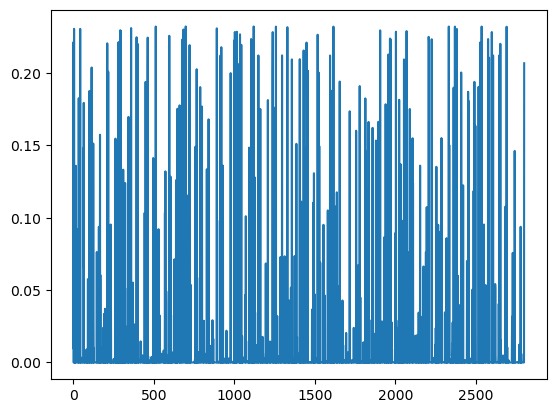

In [26]:
from matplotlib import pyplot as plt

plt.plot(scipy.stats.norm.pdf(data['Y'], mu2_k[-1], np.sqrt(sigma2_square_k[-1])))

In [23]:
np.array(data['Y'])[1439]

-27.694428076256973

In [20]:
mu2_k[-1], np.sqrt(sigma2_square_k[-1])

(0.4850135492597412, 1.7188598415328062)

In [12]:
data

,name,family_name_x,country_x,birth_year_x,was_assigned_female_x,X1,X2,X3,X4,X5,...,Y,source_index_B,source_index_A,family_name_comparison,was_assigned_female_comparison,country_comparison,birth_year_comparison,linking_score,intercept,propensity_score
5600,Johann,Zerbes,AT,1952,0,68,2.44847,-1.713873,2.247518,0.645745,...,-3.829098,2,0,0,1,0,0,-11.653488,1,0.007902
5601,Johann,Zerbes,AT,1952,0,68,2.44847,-1.713873,2.247518,0.645745,...,-0.046162,2,1,0,0,0,0,-15.898071,1,0.007902
5602,Johann,Zerbes,AT,1952,0,68,2.44847,-1.713873,2.247518,0.645745,...,9.564586,2,2,0,1,0,0,-11.653488,1,0.007902
5603,Johann,Zerbes,AT,1952,0,68,2.44847,-1.713873,2.247518,0.645745,...,-7.144302,2,3,0,1,0,0,-11.653488,1,0.007902
5604,Johann,Zerbes,AT,1952,0,68,2.44847,-1.713873,2.247518,0.645745,...,-9.477841,2,4,0,1,0,0,-11.653488,1,0.007902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8395,Johann,Zerbes,AT,1952,0,68,2.44847,-1.713873,2.247518,0.645745,...,-12.097522,2,2795,0,1,0,1,-4.830953,1,0.007902
8396,Johann,Zerbes,AT,1952,0,68,2.44847,-1.713873,2.247518,0.645745,...,-14.908596,2,2796,0,1,0,0,-11.653488,1,0.007902
8397,Johann,Zerbes,AT,1952,0,68,2.44847,-1.713873,2.247518,0.645745,...,-9.729094,2,2797,0,1,0,0,-11.653488,1,0.007902
8398,Johann,Zerbes,AT,1952,0,68,2.44847,-1.713873,2.247518,0.645745,...,-11.411735,2,2798,0,1,0,0,-11.653488,1,0.007902


In [11]:
AB[(AB.source_index_A==1439) & (AB.source_index_B==2)]

,name,family_name_x,country_x,birth_year_x,was_assigned_female_x,X1,X2,X3,X4,X5,...,Y,source_index_B,source_index_A,family_name_comparison,was_assigned_female_comparison,country_comparison,birth_year_comparison,linking_score,intercept,propensity_score
7039,Johann,Zerbes,AT,1952,0,68,2.44847,-1.713873,2.247518,0.645745,...,-27.694428,2,1439,0,1,0,0,-11.653488,1,0.007902


In [9]:
B.iloc[2,:]

name                     Johann
family_name              Zerbes
country                      AT
birth_year                 1952
was_assigned_female           0
X1                           68
X2                      2.44847
X3                    -1.713873
X4                     2.247518
X5                     0.645745
treatment                     0
Name: 2, dtype: object

In [8]:
A.iloc[1439,:]

family_name               Franco
was_assigned_female            0
country                       IT
birth_year                  1948
Y                     -27.694428
Name: 1439, dtype: object

In [16]:
probabilities.sum()

1.8620299758230717e+33

In [14]:
list(probabilities)

[284.2506342897024,
 196859.23652449113,
 28.50750958352203,
 187.94247400828584,
 0.02857333513740712,
 0.002255147123432977,
 26.398391890348062,
 75.35908927066123,
 0.017594229670688483,
 0.26637425759110983,
 0.8505325450313016,
 1758.9696902518162,
 522.2002064024647,
 86.815630816229,
 0.08129878275637412,
 1263.6850789035498,
 3.474028113319409e-06,
 1452985.9438471599,
 0.0021709791246681547,
 0.003379429904849287,
 0.000498234019793007,
 0.9904646607177191,
 437.7361543482941,
 0.0004718851768029276,
 0.005898645320779828,
 0.8209264354327631,
 0.02551198057722891,
 0.04859090589382455,
 4.888461734368134e-05,
 0.0034634795893749033,
 89.12656303734084,
 1.3324009485929327e-05,
 17759814690.3248,
 306596.09462112066,
 6.125478463534733e-05,
 0.0014459830911383142,
 5489552061.674661,
 333.3534949011338,
 6908001796.073862,
 0.005057835699302884,
 0.00010903203391896597,
 4968805924.999958,
 2557.49425586609,
 141.48786018551817,
 0.481976426022833,
 0.04672523167575459,
 1686

In [ ]:
#j = 3
#set_data = ...[AB['source_index_B']==j]



[array([ 3.850e+02, -1.000e+00,  5.290e+02, ..., -1.000e+00,  2.798e+03,
       -1.000e+00]), [-1, -1, -1, -1, -1, -1, 1544, -1, -1, 993, 1646, -1, -1, 228, -1, -1, -1, -1, -1, 1863, 659, -1, 1285, -1, -1, -1, -1, -1, 2311, -1, 1931, -1, -1, -1, -1, 1456, -1, -1, 821, -1, 2694, -1, -1, 165, 771, -1, -1, -1, 1825, -1, -1, 314, -1, -1, -1, -1, -1, -1, -1, 2262, -1, -1, -1, -1, -1, -1, -1, -1, 2420, -1, 267, 1780, 2048, 645, -1, -1, -1, -1, 594, -1, 2071, -1, 2480, -1, 1728, -1, -1, 180, -1, 158, 7, 638, -1, 2164, -1, 30, -1, -1, 260, 521, 1344, -1, -1, 570, -1, -1, -1, 830, 457, -1, -1, -1, 156, -1, -1, -1, 2272, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1509, -1, 824, 2155, -1, 296, -1, -1, -1, -1, -1, 1938, -1, -1, -1, 112, 1336, -1, -1, -1, -1, 2076, 1110, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1022, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1560, 792, 2746, -1, -1, 159, -1, -1, -1, -1, 2297, 1125, -1, -1, -1, -1, -1, -1, -1, 261, -1, -1, -1, -1, -1, -1, -1, 609, -1, 1108, -1, -1, 1356, 543, -1, -1,